# Stock Market Data Analysis with MLFlow
This notebook demonstrates data ingestion, analysis, and preprocessing using sklearn pipelines with MLFlow tracking

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"MLflow version: {mlflow.__version__}")
print(f"Sklearn version: {sklearn.__version__}")

MLflow version: 3.5.1
Sklearn version: 1.7.2


## Configuration
Set up MLFlow tracking URI (update VM's IP)

# Set MLFlow tracking URI - update with VM IP
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Stock Market Analysis Pipeline")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('Stock Market Analysis Pipeline')}")

## 1. Data Ingestion

In [3]:
# Load the dataset
df = pd.read_csv("stock_market_dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
df.info()
print(f"\nFirst few rows:")
df.head()

Dataset shape: (50349, 18)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50349 entries, 0 to 50348
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Stock            50349 non-null  object 
 1   Date             50349 non-null  object 
 2   Open             50349 non-null  float64
 3   High             50349 non-null  float64
 4   Low              50349 non-null  float64
 5   Close            50349 non-null  float64
 6   Volume           50349 non-null  int64  
 7   SMA_10           50349 non-null  float64
 8   RSI              50349 non-null  float64
 9   MACD             50349 non-null  float64
 10  Bollinger_Upper  50349 non-null  float64
 11  Bollinger_Lower  50349 non-null  float64
 12  GDP_Growth       50349 non-null  float64
 13  Inflation_Rate   50349 non-null  float64
 14  Interest_Rate    50349 non-null  float64
 15  Sentiment_Score  50349 non-null  float64
 16  Next_Close      

,Stock,Date,Open,High,Low,Close,Volume,SMA_10,RSI,MACD,Bollinger_Upper,Bollinger_Lower,GDP_Growth,Inflation_Rate,Interest_Rate,Sentiment_Score,Next_Close,Target
0,AAPL,2010-01-04,445.627510,465.464143,431.513035,450.378213,2441288,301.310351,64.061774,2.449751,464.398638,438.231589,2.845199,1.505217,4.360374,-0.079418,445.714557,0
1,AAPL,2010-01-05,441.194244,449.726464,432.618124,437.397748,4714199,280.015623,52.032235,-3.726473,450.099041,431.018080,3.352677,1.516110,2.309996,0.511900,439.507357,1
2,AAPL,2010-01-07,395.417421,399.413060,385.055059,388.718345,3948217,323.131496,71.817441,-4.215862,396.010670,374.092744,3.471209,2.256823,0.984588,0.049279,387.335810,0
3,AAPL,2010-01-11,478.631057,501.639769,461.991967,484.401144,3637733,273.944016,67.133451,1.574418,496.399599,479.317188,2.962110,2.238436,1.754234,0.737874,476.642532,0
4,AAPL,2010-01-12,179.950904,183.900759,175.076588,181.516782,693492,237.354447,84.797294,1.552505,189.479672,171.610610,2.727858,2.378014,2.562107,-0.905092,182.863272,1


## 2. Exploratory Data Analysis

In [4]:
# Summary statistics
summary_stats = df.describe()
print("Summary Statistics:")
summary_stats

Summary Statistics:


,Open,High,Low,Close,Volume,SMA_10,RSI,MACD,Bollinger_Upper,Bollinger_Lower,GDP_Growth,Inflation_Rate,Interest_Rate,Sentiment_Score,Next_Close,Target
count,50349.000000,50349.000000,50349.000000,50349.000000,5.034900e+04,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000,50349.000000
mean,274.949818,281.765893,268.061694,274.924734,2.547134e+06,274.910267,49.827072,0.007013,284.924427,264.916157,3.000355,2.250040,2.746320,0.001429,274.943789,0.501976
std,129.861782,133.040144,126.627094,129.786177,1.413136e+06,40.732721,23.097843,2.887802,129.831090,129.825109,0.289456,0.433514,1.297482,0.577099,129.855561,0.500001
min,49.106664,50.227411,47.755292,50.078817,1.000890e+05,91.000865,10.000911,-4.999912,55.160167,35.759134,2.500040,1.500009,0.500014,-0.999921,49.443977,0.000000
25%,162.088317,166.265621,158.015601,162.105889,1.321219e+06,247.286597,29.847647,-2.511063,172.264659,152.149801,2.750128,1.871944,1.626444,-0.499875,162.272760,0.000000
50%,274.928366,281.961442,268.121257,275.005601,2.546261e+06,274.911668,49.906363,0.011629,285.012100,264.655584,2.999740,2.251659,2.746131,0.004065,275.056340,1.000000
75%,386.653578,396.218846,376.748125,386.636207,3.767910e+06,302.526785,69.821850,2.516192,396.673124,376.636601,3.250861,2.624896,3.862460,0.499449,386.790854,1.000000
max,509.361090,524.861970,499.339660,499.962629,4.999977e+06,438.897688,89.999704,4.999610,514.789524,494.472084,3.499968,2.999991,4.999880,0.999966,509.341161,1.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])
print(f"\nTotal missing values: {missing_values.sum()}")

Missing Values:
Series([], dtype: int64)

Total missing values: 0


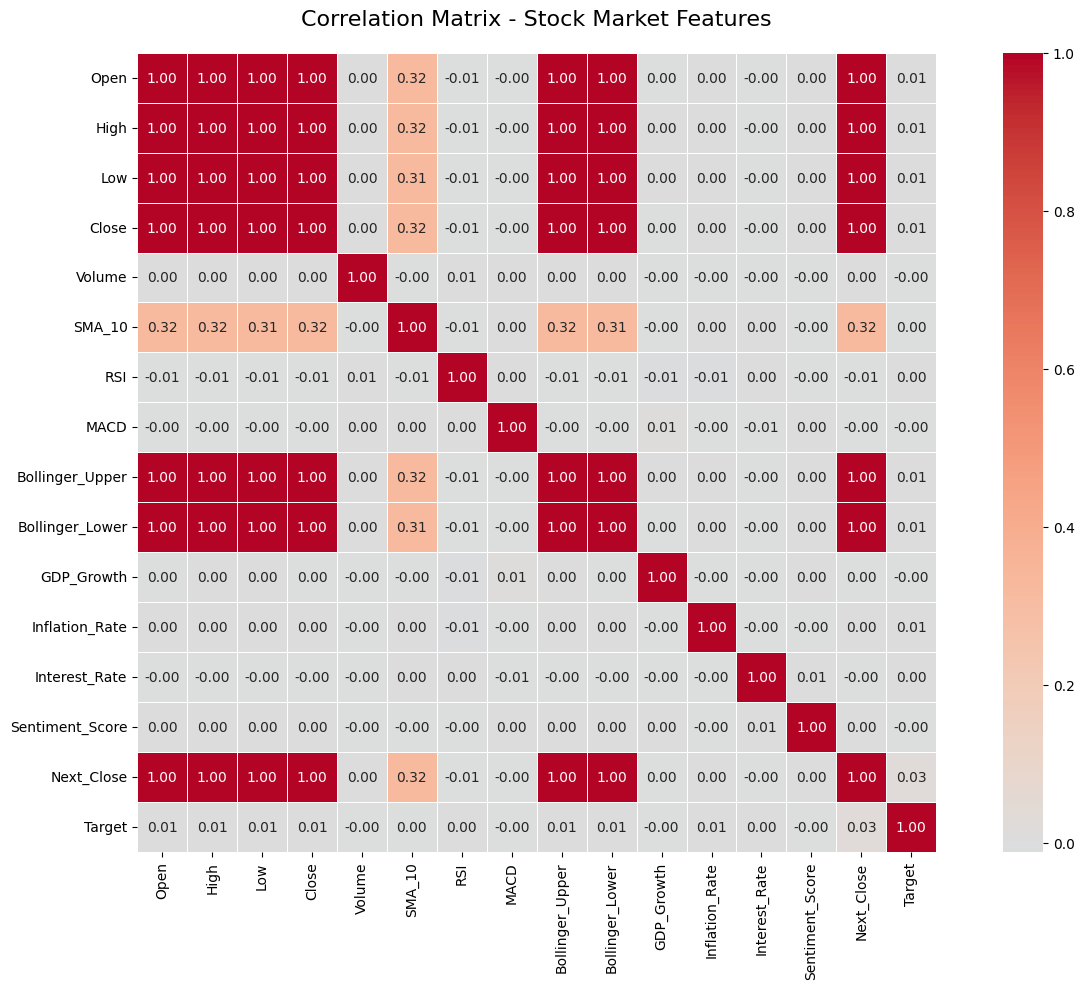

Correlation matrix saved!


In [6]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Matrix - Stock Market Features', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Correlation matrix saved!")

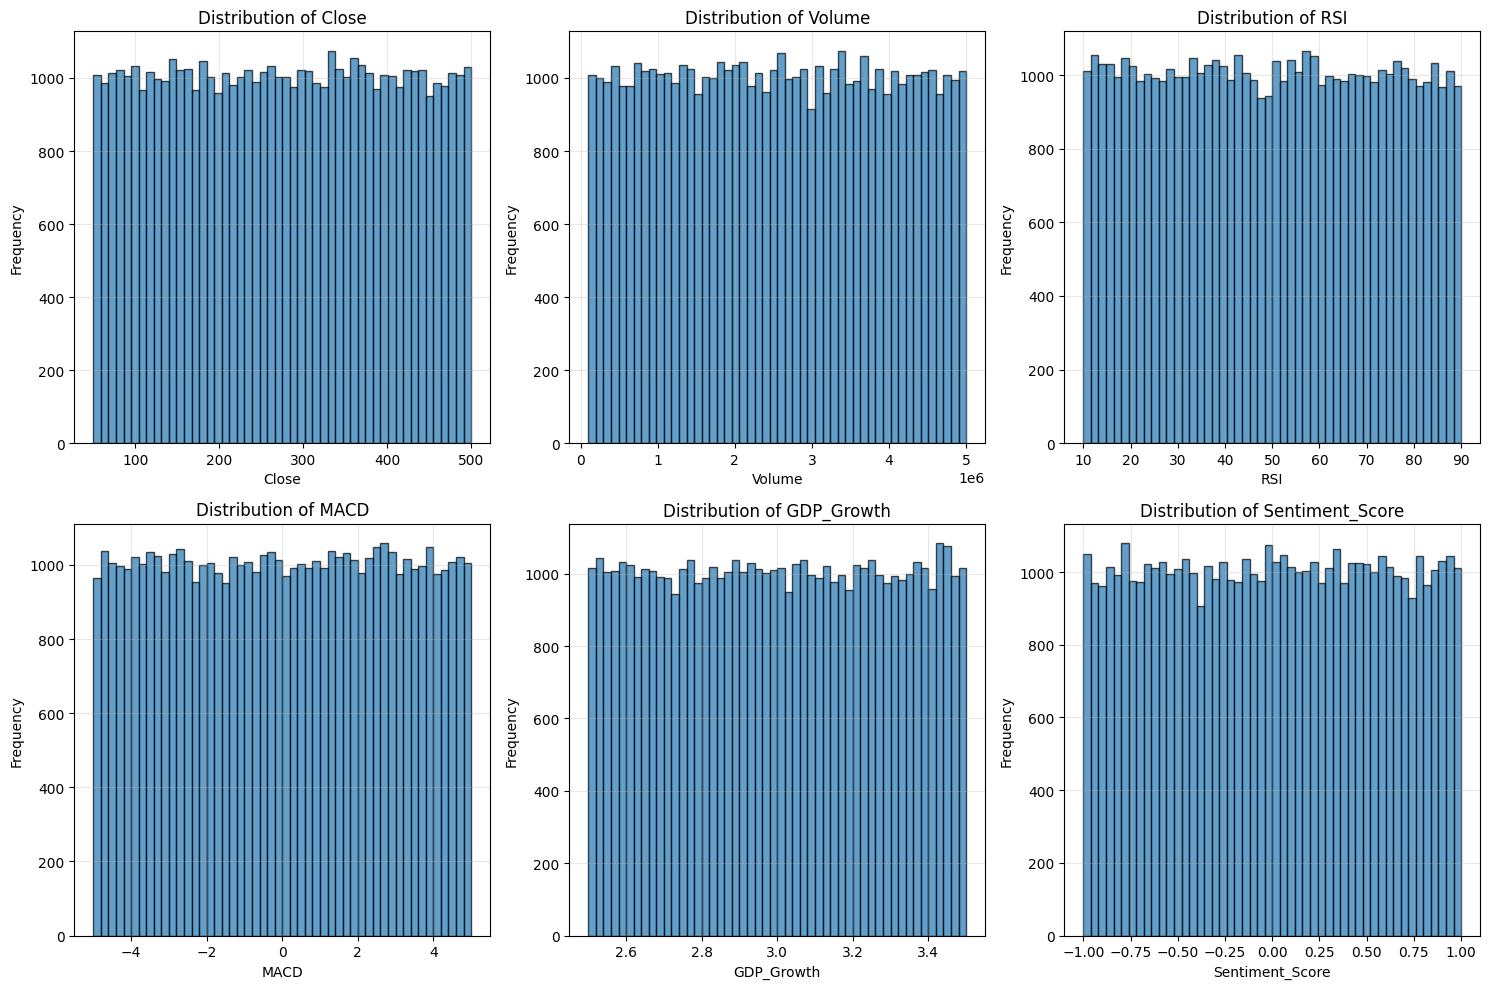

Distribution plots saved!


In [7]:
# Distribution of key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ['Close', 'Volume', 'RSI', 'MACD', 'GDP_Growth', 'Sentiment_Score']

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    axes[row, col].hist(df[feature].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Distribution plots saved!")

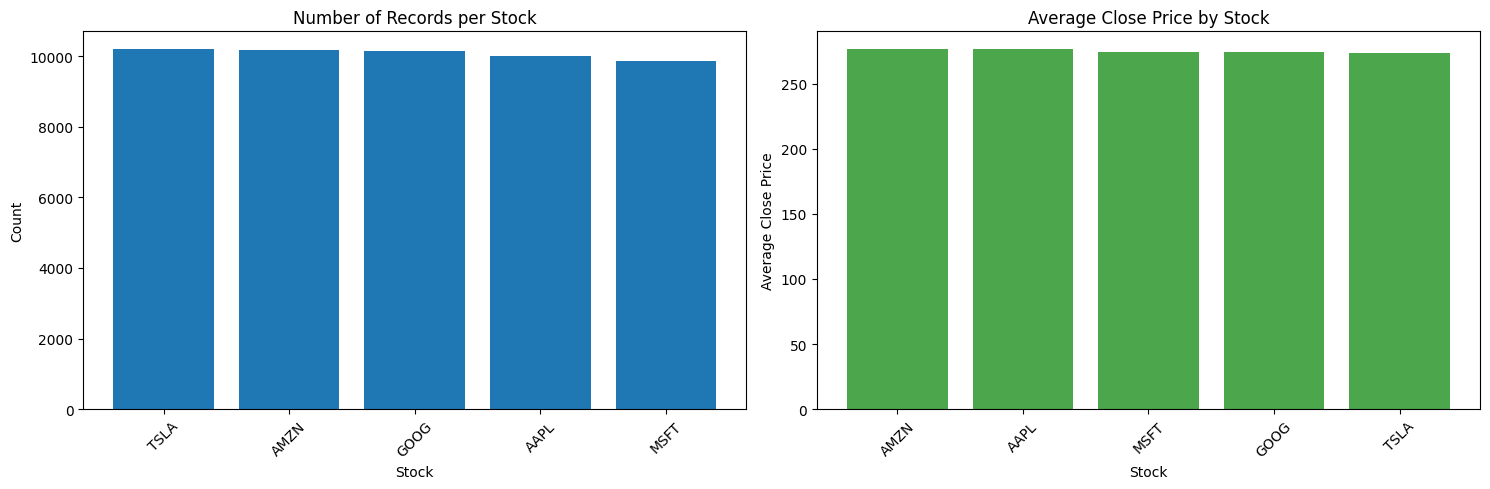

Stock analysis plots saved!


In [8]:
# Stock-wise analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count by stock
stock_counts = df['Stock'].value_counts()
axes[0].bar(stock_counts.index, stock_counts.values)
axes[0].set_title('Number of Records per Stock')
axes[0].set_xlabel('Stock')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Average close price by stock
avg_close = df.groupby('Stock')['Close'].mean().sort_values(ascending=False)
axes[1].bar(avg_close.index, avg_close.values, color='green', alpha=0.7)
axes[1].set_title('Average Close Price by Stock')
axes[1].set_xlabel('Stock')
axes[1].set_ylabel('Average Close Price')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('stock_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Stock analysis plots saved!")

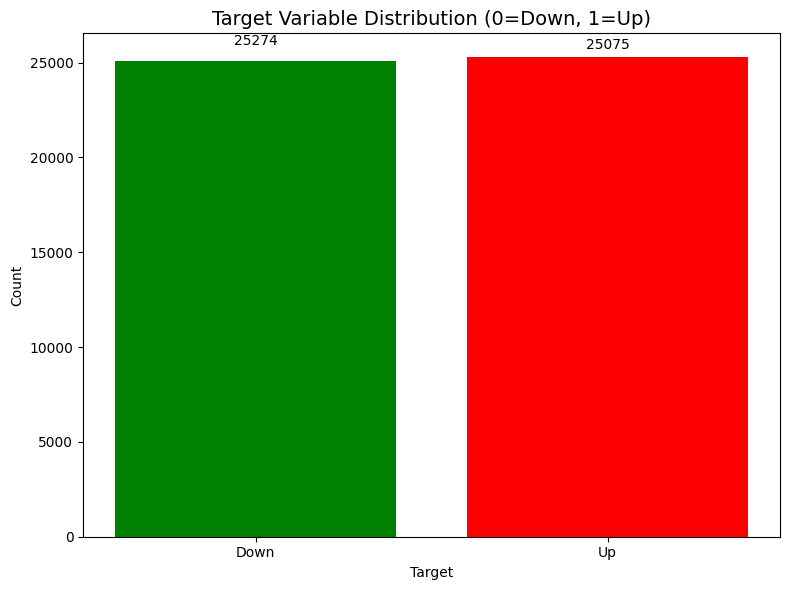

Target balance: 50.20% Up


In [9]:
# Target variable distribution
plt.figure(figsize=(8, 6))
target_counts = df['Target'].value_counts()
plt.bar(target_counts.index, target_counts.values, color=['red', 'green'])
plt.title('Target Variable Distribution (0=Down, 1=Up)', fontsize=14)
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Down', 'Up'])
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Target balance: {target_counts[1]/(target_counts[0]+target_counts[1])*100:.2f}% Up")

## 3. Data Preparation with Sklearn Pipeline

In [10]:
# Separate features and target
# Drop non-numeric and target columns
X = df.drop(['Stock', 'Date', 'Target', 'Next_Close'], axis=1)
y = df['Target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (50349, 14)
Target shape: (50349,)

Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'GDP_Growth', 'Inflation_Rate', 'Interest_Rate', 'Sentiment_Score']


In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())

Training set size: 40279
Test set size: 10070

Training set target distribution:
Target
1    20219
0    20060
Name: count, dtype: int64


In [12]:
# Create preprocessing pipeline
# Using RobustScaler to handle outliers better in financial data
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle any missing values
    ('scaler', RobustScaler())  # Robust to outliers
])

print("Preprocessing Pipeline:")
print(preprocessing_pipeline)

Preprocessing Pipeline:
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler())])


In [13]:
# Fit the pipeline on training data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

# Convert back to DataFrame for easier analysis
X_train_processed_df = pd.DataFrame(
    X_train_processed, 
    columns=X.columns,
    index=X_train.index
)
X_test_processed_df = pd.DataFrame(
    X_test_processed, 
    columns=X.columns,
    index=X_test.index
)

print("\nProcessed data statistics:")
X_train_processed_df.describe()

Processed training data shape: (40279, 14)
Processed test data shape: (10070, 14)

Processed data statistics:


,Open,High,Low,Close,Volume,SMA_10,RSI,MACD,Bollinger_Upper,Bollinger_Lower,GDP_Growth,Inflation_Rate,Interest_Rate,Sentiment_Score
count,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000,40279.000000
mean,-0.002526,-0.002379,-0.001686,-0.001606,0.001524,-0.001661,-0.001827,0.000335,-0.001813,-0.000430,0.002423,-0.002109,-0.001266,-0.000762
std,0.579240,0.579830,0.579957,0.579201,0.578469,0.737785,0.577360,0.574353,0.579387,0.579062,0.579168,0.575700,0.581085,0.577488
min,-1.009735,-1.011365,-1.009905,-1.004819,-1.001407,-3.328341,-0.999058,-0.994695,-1.023057,-1.021342,-1.001312,-0.997457,-1.007491,-1.002900
25%,-0.505335,-0.505514,-0.505166,-0.504113,-0.499302,-0.501884,-0.501273,-0.500321,-0.504154,-0.503201,-0.495613,-0.504273,-0.502831,-0.501253
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.494665,0.494486,0.494834,0.495887,0.500698,0.498116,0.498727,0.499679,0.495846,0.496799,0.504387,0.495727,0.497169,0.498747
max,1.043475,1.057724,1.055072,1.003073,1.005033,2.965787,1.003014,0.994762,1.024330,1.023631,1.000815,0.994010,1.006798,0.998893


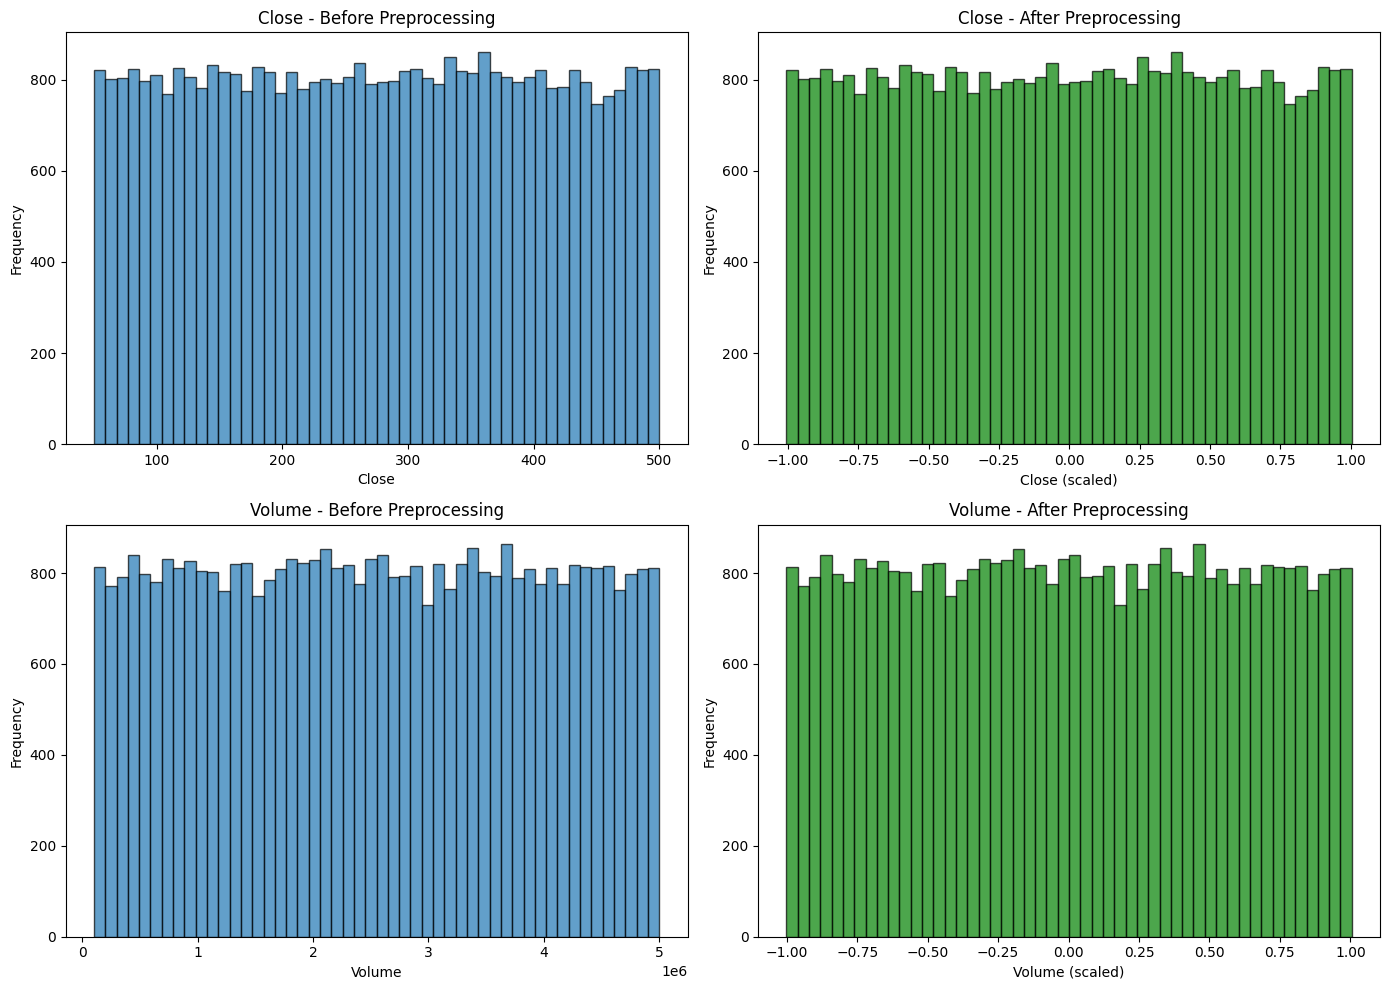

Preprocessing comparison saved!


In [14]:
# Visualize the effect of preprocessing
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
features_to_compare = ['Close', 'Volume']

for idx, feature in enumerate(features_to_compare):
    # Before preprocessing
    axes[idx, 0].hist(X_train[feature], bins=50, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'{feature} - Before Preprocessing')
    axes[idx, 0].set_xlabel(feature)
    axes[idx, 0].set_ylabel('Frequency')
    
    # After preprocessing
    axes[idx, 1].hist(X_train_processed_df[feature], bins=50, 
                      edgecolor='black', alpha=0.7, color='green')
    axes[idx, 1].set_title(f'{feature} - After Preprocessing')
    axes[idx, 1].set_xlabel(f'{feature} (scaled)')
    axes[idx, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('preprocessing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Preprocessing comparison saved!")

## 4. Log Everything to MLFlow

In [16]:
# Start MLFlow run and log everything
with mlflow.start_run(run_name="Stock_Data_Pipeline_" + datetime.now().strftime("%Y%m%d_%H%M%S")):
    
    # Log parameters
    mlflow.log_param("dataset_name", "stock_market_dataset.csv")
    mlflow.log_param("total_samples", df.shape[0])
    mlflow.log_param("total_features", X.shape[1])
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    mlflow.log_param("test_split_ratio", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("imputation_strategy", "median")
    mlflow.log_param("scaling_method", "RobustScaler")
    mlflow.log_param("unique_stocks", df['Stock'].nunique())
    
    # Log metrics
    mlflow.log_metric("target_balance_percentage", 
                     (y.sum() / len(y)) * 100)
    mlflow.log_metric("missing_values_total", df.isnull().sum().sum())
    mlflow.log_metric("avg_close_price", df['Close'].mean())
    mlflow.log_metric("avg_volume", df['Volume'].mean())
    mlflow.log_metric("avg_rsi", df['RSI'].mean())
    
    # Log the preprocessing pipeline
    mlflow.sklearn.log_model(
        preprocessing_pipeline, 
        "preprocessing_pipeline",
        registered_model_name="StockDataPreprocessor"
    )
    
    # Log artifacts (visualizations)
    mlflow.log_artifact('correlation_matrix.png')
    mlflow.log_artifact('feature_distributions.png')
    mlflow.log_artifact('stock_analysis.png')
    mlflow.log_artifact('target_distribution.png')
    mlflow.log_artifact('preprocessing_comparison.png')
    
    # Log text summaries
    mlflow.log_text(summary_stats.to_string(), "summary_statistics.txt")
    mlflow.log_text(correlation_matrix.to_string(), "correlation_matrix.txt")
    
    # Log dataset info
    dataset_info = f"""Stock Market Dataset Information
    =====================================
    Total Records: {df.shape[0]}
    Total Features: {df.shape[1]}
    Date Range: {df['Date'].min()} to {df['Date'].max()}
    Unique Stocks: {df['Stock'].nunique()}
    Stocks: {', '.join(df['Stock'].unique())}
    
    Features:
    {', '.join(df.columns)}
    
    Target Distribution:
    Down (0): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)
    Up (1): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)
    """
    mlflow.log_text(dataset_info, "dataset_info.txt")
    
    # Save processed data samples
    X_train_processed_df.head(100).to_csv('train_processed_sample.csv', index=False)
    mlflow.log_artifact('train_processed_sample.csv')
    
    print(" All data, visualizations, and pipeline logged to MLFlow!")
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    print(f"Experiment ID: {mlflow.active_run().info.experiment_id}")

KeyboardInterrupt: 

In [ ]:
# View experiment information
experiment = mlflow.get_experiment_by_name("Stock Market Analysis Pipeline")
print(f"Experiment Name: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"\nView your results at: {mlflow.get_tracking_uri()}")